# Homework 2: Linear Models for Regression and Classification

Due 10/21 at 11:59pm

In this notebook, we will be implementing three linear models: linear regression, logistic regression, and SVM. We will see that despite some of their differences at the surface, these linear models (and many machine learning models in general) are fundamentally doing the same thing - that is, optimizing model parameters to minimize a loss function on data.

**Note: There are two notebooks in Homework 2. Please also complete the other notebook `HW2_Decision_Trees.ipynb` for full credit on this assignment.**

![comic](https://pbs.twimg.com/media/ESlslPWWkAAcNP-?format=jpg&name=900x900)

In [165]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder 
from sklearn.svm import LinearSVC, SVC

## Part 1: Linear Regression

### 1.1 Data Exploration

In part 1, we will use two datasets to train and evaluate our linear regression model. 

The first dataset will be a synthetic dataset sampled from the following equations:

$$
\epsilon \sim \text{Normal}(0, 3) \\
y = 3x + 10 + \epsilon
$$

In [166]:
np.random.seed(0)
epsilon = np.random.normal(0, 3, 100)   # Sample epsilon from a Normal distribution
x = np.linspace(0, 10, 100)             # Sample x evenly between 0 and 100
y = 3 * x + 10 + epsilon

Note that the above dataset satisfies all the assumptions of a linear regression model:
- Linearity: $y$ is a linear (technically affine) function of $x$.
- Independence: the $x$'s are independently drawn, and not dependent on each other.
- Homoscedasticity: the $\epsilon$'s, and thus the $y$'s, have constant variance.
- Normality: the $\epsilon$'s are drawn from a Normal distribution (i.e. Normally-distributed errors)

These properties, as well as the simplicity of this dataset, will make it a good test case to check if our linear regression model is working properly.

**Plot y vs x in the synthetic dataset as a scatter plot. Label your axes and make sure your y-axis starts from 0.**

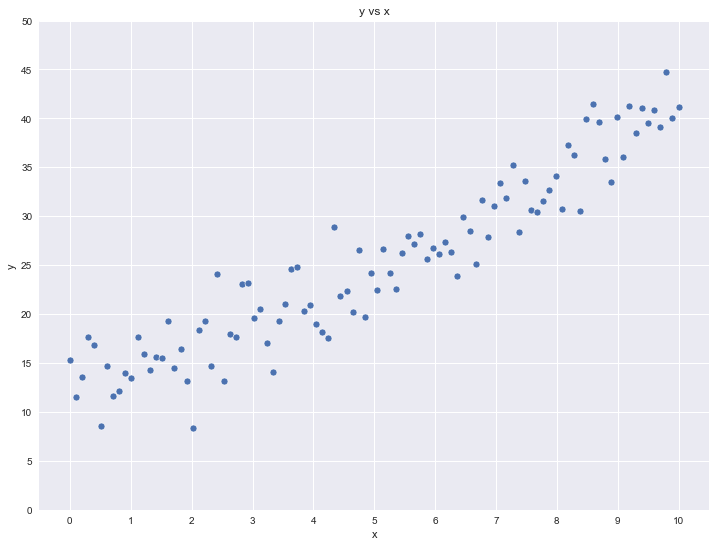

In [167]:
### Your code here
plt.figure(figsize=(12,9))

sns.scatterplot(x=x, y=y)

plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, max(y)+10, 5))
plt.title('y vs x');

The second dataset we will be using is an [auto MPG dataset](https://archive.ics.uci.edu/ml/datasets/Auto+MPG). This dataset contains various characteristics for around 400 cars. We will use linear regression to predict the mpg label from seven features (4 continuous, 3 discrete).

In [168]:
# Load auto MPG dataset
auto_mpg_df = pd.read_csv('auto-mpg.csv')

# drop some rows with missing entries
auto_mpg_df = auto_mpg_df[auto_mpg_df['horsepower'] != '?']
# Cast horsepower column to float
auto_mpg_df['horsepower'] = auto_mpg_df['horsepower'].astype(float)

auto_mpg_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [169]:
auto_mpg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [170]:
# check for missing values
for col in auto_mpg_df.columns.tolist():
    print('---- {} ---'.format(col))
    print(auto_mpg_df[col].value_counts())
    print('\n')

---- mpg ---
13.0    20
14.0    19
18.0    17
15.0    16
26.0    14
        ..
26.5     1
19.1     1
33.8     1
28.1     1
31.8     1
Name: mpg, Length: 127, dtype: int64


---- cylinders ---
4    199
8    103
6     83
3      4
5      3
Name: cylinders, dtype: int64


---- displacement ---
97.0     21
350.0    18
98.0     17
318.0    17
250.0    17
         ..
83.0      1
181.0     1
81.0      1
96.0      1
104.0     1
Name: displacement, Length: 81, dtype: int64


---- horsepower ---
150.0    22
90.0     20
88.0     19
110.0    18
100.0    17
         ..
61.0      1
77.0      1
193.0     1
138.0     1
54.0      1
Name: horsepower, Length: 93, dtype: int64


---- weight ---
2130.0    4
1985.0    4
2265.0    3
2720.0    3
2125.0    3
         ..
2605.0    1
1945.0    1
2234.0    1
3570.0    1
4499.0    1
Name: weight, Length: 346, dtype: int64


---- acceleration ---
14.5    23
15.5    21
16.0    16
14.0    16
13.5    15
        ..
18.3     1
11.1     1
19.9     1
20.7     1
11.3     1


No missing values found

In [171]:
auto_mpg_df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [172]:
# Split data into features and labels
auto_mpg_X = auto_mpg_df.drop(columns=['mpg'])
auto_mpg_y = auto_mpg_df['mpg']

**Plot the distribution of the label (mpg) using a histogram.**

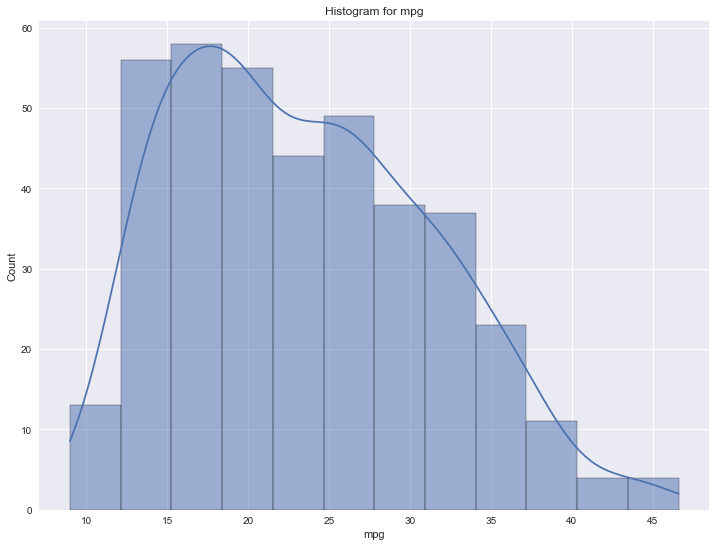

In [173]:
plt.figure(figsize=(12,9))

sns.histplot(x=auto_mpg_y,
             kde=True)

plt.xlabel('mpg')
plt.ylabel('Count')
plt.title('Histogram for mpg');

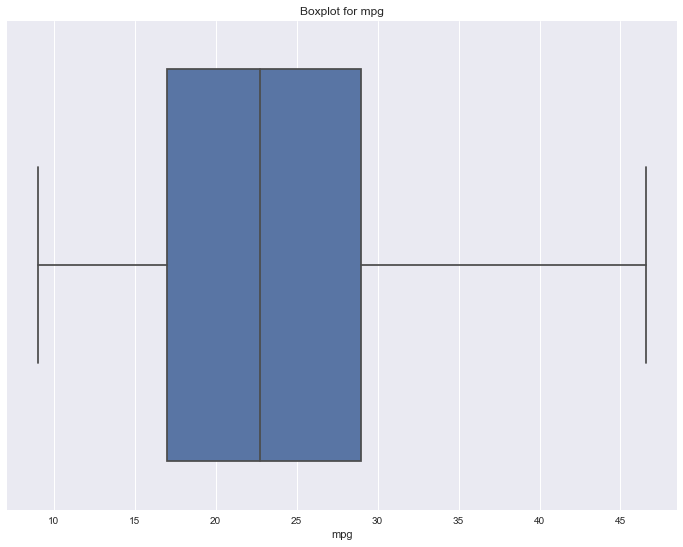

In [174]:
plt.figure(figsize=(12,9))

sns.boxplot(x=auto_mpg_y)

plt.xlabel('mpg')
plt.title('Boxplot for mpg');

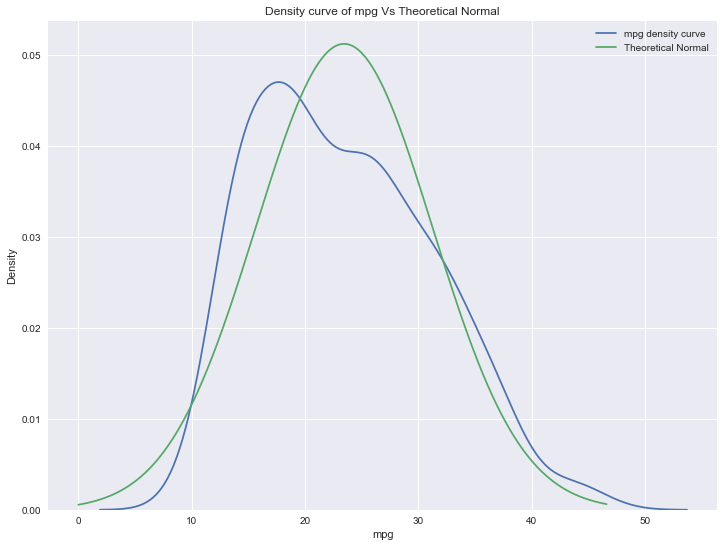

In [175]:
plt.figure(figsize=(12,9))

sns.kdeplot(auto_mpg_y, label='mpg density curve')

mu = np.mean(auto_mpg_y)
sigma = np.std(auto_mpg_y)

x_axis = np.linspace(0, auto_mpg_y.max(), 10000)
plt.plot(x_axis, stats.norm.pdf(x_axis, mu, sigma), label='Theoretical Normal')

plt.xlabel('mpg')
plt.ylabel('Density')
plt.title('Density curve of mpg Vs Theoretical Normal')
plt.legend();

We see that mpg is moderately right skewed with no outliers. This means that there are more cars with low mpg than there are with high mpg

In [176]:
auto_mpg_df['log_mpg'] = np.log(auto_mpg_df['mpg'])
auto_mpg_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,log_mpg
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,2.890372
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,2.708050
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,2.890372
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,2.772589
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,2.833213


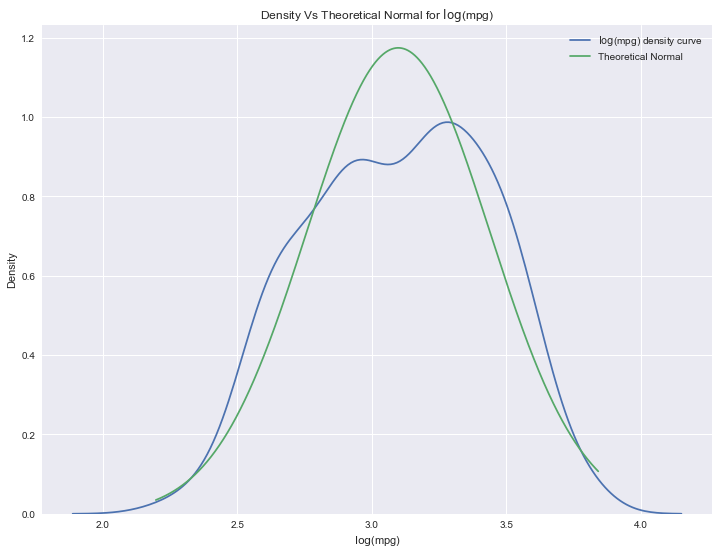

In [177]:
plt.figure(figsize=(12,9))

sns.kdeplot(np.log(auto_mpg_y), legend='$\log$(mpg)', label='$\log$(mpg) density curve')

mu = np.mean(np.log(auto_mpg_y))
sigma = np.std(np.log(auto_mpg_y))

x_axis = np.linspace(np.log(auto_mpg_y).min(), np.log(auto_mpg_y).max(), 10000)
plt.plot(x_axis, stats.norm.pdf(x_axis, mu, sigma), label='Theoretical Normal')

plt.title('Density Vs Theoretical Normal for $\log$(mpg)')
plt.xlabel('$\log$(mpg)')
plt.ylabel('Density')
plt.legend();

We see that log transformation on mpg kind of makes it symmetrical

**Plot the relationships between the label (mpg) and the continuous features (displacement, horsepower, weight, acceleration) using a small multiple of scatter plots. Make sure to label the axes.**

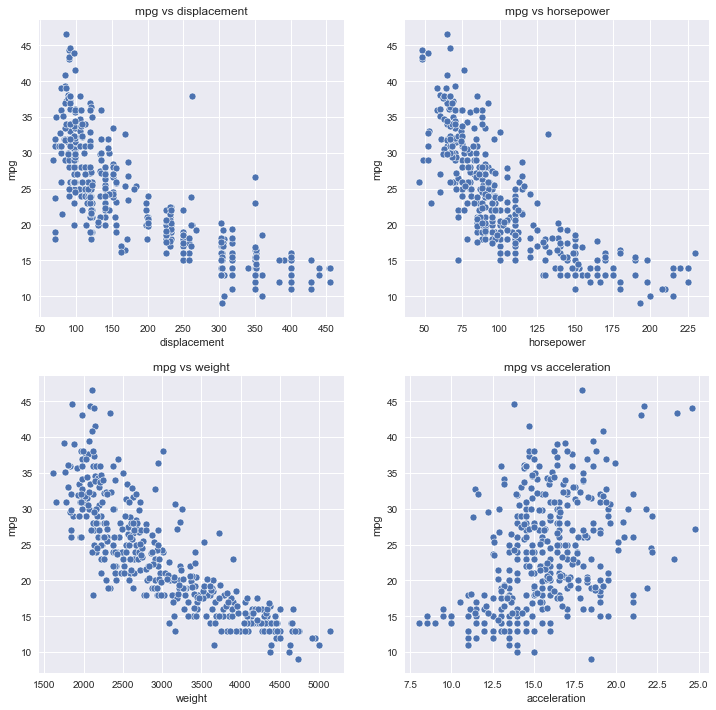

In [178]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax[0][0].set_title('mpg vs displacement')
ax[0][1].set_title('mpg vs horsepower')
ax[1][0].set_title('mpg vs weight')
ax[1][1].set_title('mpg vs acceleration')

sns.scatterplot(data=auto_mpg_df, x='displacement', y='mpg', ax=ax[0][0])
sns.scatterplot(data=auto_mpg_df, x='horsepower', y='mpg', ax=ax[0][1])
sns.scatterplot(data=auto_mpg_df, x='weight', y='mpg', ax=ax[1][0])
sns.scatterplot(data=auto_mpg_df, x='acceleration', y='mpg', ax=ax[1][1])

for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('mpg')
        
ax[0][0].set_xlabel('displacement')
ax[0][1].set_xlabel('horsepower')
ax[1][0].set_xlabel('weight')
ax[1][1].set_xlabel('acceleration');

**Plot the relationships between the label (mpg) and the discrete features (cylinders, model year, origin) using a small multiple of box plots. Make sure to label the axes.**

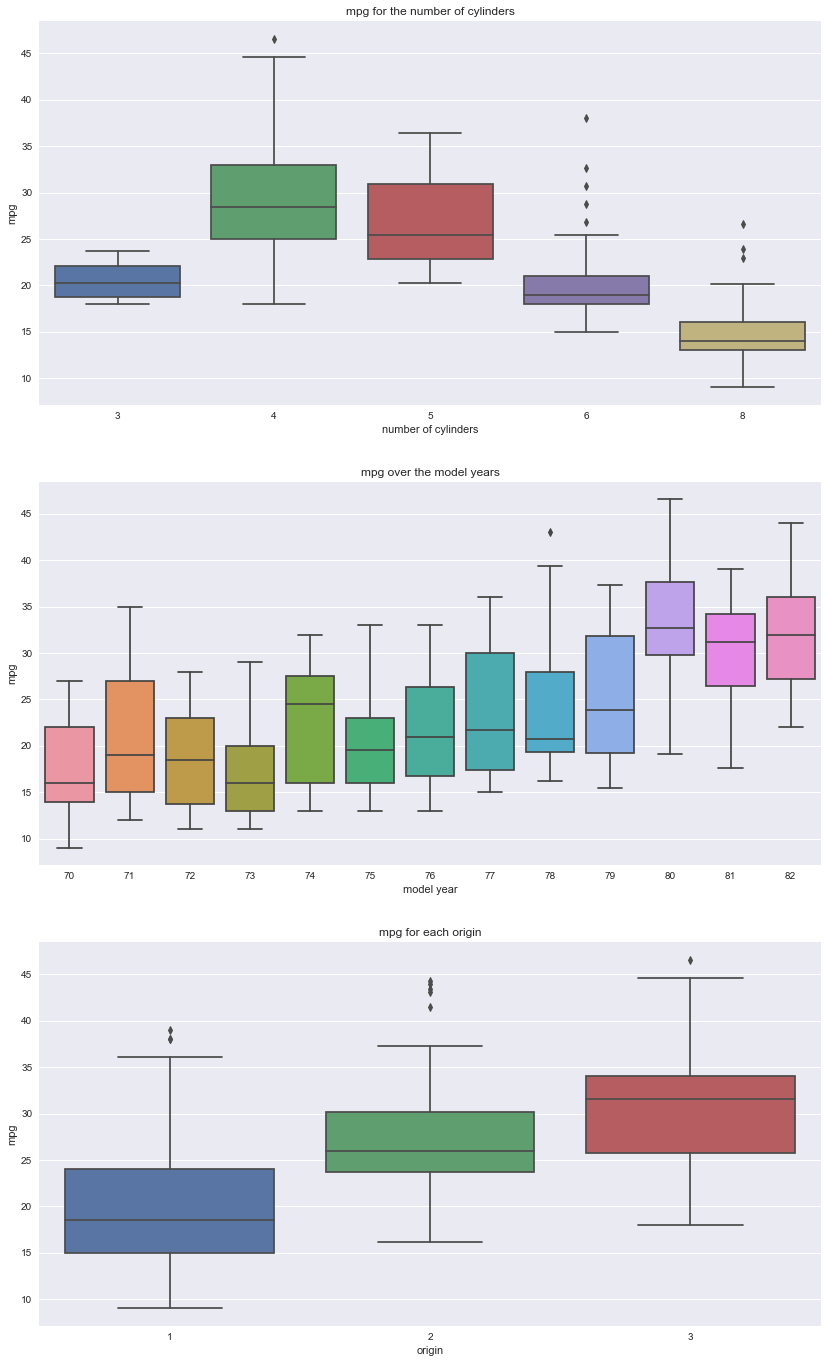

In [179]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14,24))
ax[0].set_title('mpg for the number of cylinders')
ax[1].set_title('mpg over the model years')
ax[2].set_title('mpg for each origin')

sns.boxplot(data=auto_mpg_df, x='cylinders', y='mpg', ax=ax[0])
sns.boxplot(data=auto_mpg_df, x='model year', y='mpg', ax=ax[1])
sns.boxplot(data=auto_mpg_df, x='origin', y='mpg', ax=ax[2])


for i in range(3):
    ax[i].set_ylabel('mpg')

ax[0].set_xlabel('number of cylinders')
ax[1].set_xlabel('model year')
ax[2].set_xlabel('origin');


**From the visualizations above, do you think linear regression is a good model for this problem? Why and/or why not?**

These features don't really seem to be linearly related to mpg. We can see that the scatter plots, except for mpg vs acceleration, are somewhat curved. mpg vs acceleration scatter plot seems to portray no particular relationship between the two. I wouldn't mind fitting a linear regression on this data but I believe it would instead be better to regress $\ln(mpg)$ on the given features. Consider the following graphs:

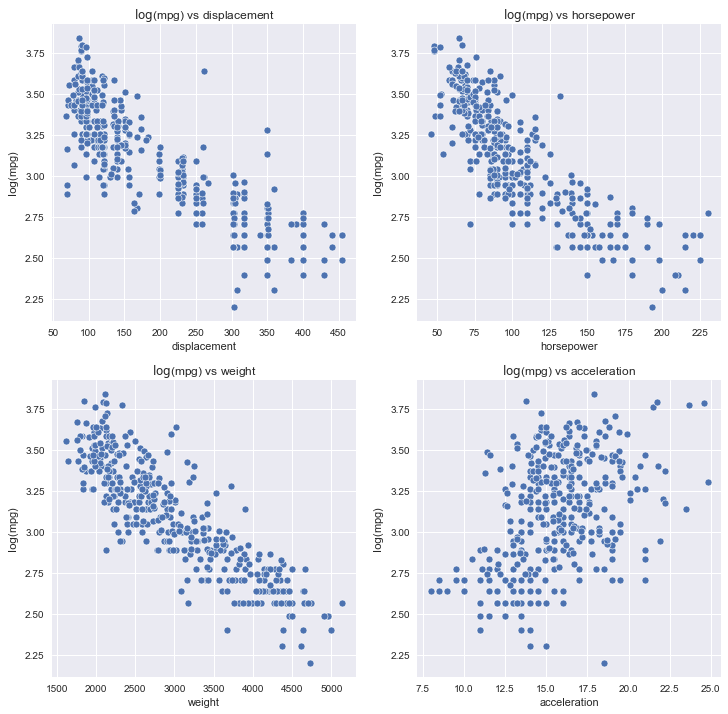

In [180]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax[0][0].set_title('$\log$(mpg) vs displacement')
ax[0][1].set_title('$\log$(mpg) vs horsepower')
ax[1][0].set_title('$\log$(mpg) vs weight')
ax[1][1].set_title('$\log$(mpg) vs acceleration')

sns.scatterplot(data=auto_mpg_df, x='displacement', y='log_mpg', ax=ax[0][0])
sns.scatterplot(data=auto_mpg_df, x='horsepower', y='log_mpg', ax=ax[0][1])
sns.scatterplot(data=auto_mpg_df, x='weight', y='log_mpg', ax=ax[1][0])
sns.scatterplot(data=auto_mpg_df, x='acceleration', y='log_mpg', ax=ax[1][1])

for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('$\log$(mpg)')
        
ax[0][0].set_xlabel('displacement')
ax[0][1].set_xlabel('horsepower')
ax[1][0].set_xlabel('weight')
ax[1][1].set_xlabel('acceleration');

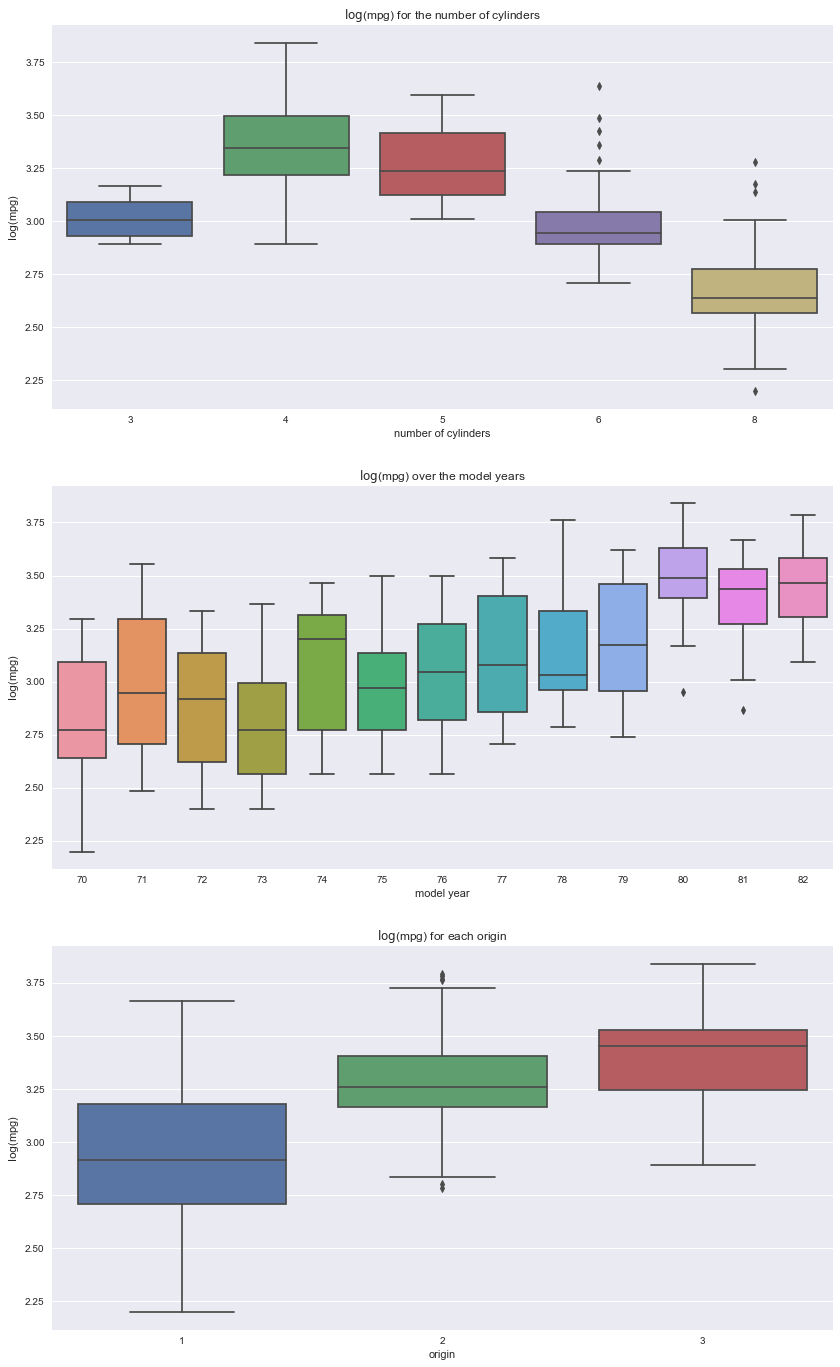

In [181]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14,24))
ax[0].set_title('$\log$(mpg) for the number of cylinders')
ax[1].set_title('$\log$(mpg) over the model years')
ax[2].set_title('$\log$(mpg) for each origin')

sns.boxplot(data=auto_mpg_df, x='cylinders', y='log_mpg', ax=ax[0])
sns.boxplot(data=auto_mpg_df, x='model year', y='log_mpg', ax=ax[1])
sns.boxplot(data=auto_mpg_df, x='origin', y='log_mpg', ax=ax[2])


for i in range(3):
    ax[i].set_ylabel('$\log$(mpg)')

ax[0].set_xlabel('number of cylinders')
ax[1].set_xlabel('model year')
ax[2].set_xlabel('origin');

Now we can observe a linear relationship between features and mpg, except for acceleration. 

Let us regress $\ln(mpg)$ on the given features

### 1.2 Data Pre-processing

Before we can fit a linear regression model, there are several pre-processing steps we should apply to the datasets:
1. Encode categorial features appropriately.
2. Split the dataset into training (60%), validation (20%), and test (20%) sets.
3. Standardize the columns in the feature matrices X_train, X_val, and X_test to have zero mean and unit variance. To avoid information leakage, learn the standardization parameters (mean, variance) from X_train, and apply it to X_train, X_val, and X_test.
4. Add a column of ones to the feature matrices X_train, X_val, and X_test. This is a common trick so that we can learn a coefficient for the bias term of a linear model.

The processing steps on the synthetic dataset have been provided for you below as a reference:

In [182]:
X = x.reshape((100, 1))   # Turn the x vector into a feature matrix X

# 1. No categorical features in the synthetic dataset (skip this step)

# 2. Split the dataset into training (60%), validation (20%), and test (20%) sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

# 3. Standardize the columns in the feature matrices
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # Fit and transform scalar on X_train
X_val = scaler.transform(X_val)           # Transform X_val
X_test = scaler.transform(X_test)         # Transform X_test

# 4. Add a column of ones to the feature matrices
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

print(X_train[:5], '\n\n', y_train[:5])

[[ 1.          0.53651502]
 [ 1.         -1.00836082]
 [ 1.         -0.72094206]
 [ 1.         -0.25388657]
 [ 1.          0.64429705]] 

 [25.10940496 14.74320191 20.52842695 21.80437679 31.0649271 ]


In [183]:
# Verify that columns (other than the ones column) have 0 mean, 1 variance
print(X_train.mean(axis=0), X_train.std(axis=0))
print(X_val.mean(axis=0), X_val.std(axis=0))
print(X_test.mean(axis=0), X_test.std(axis=0))

[ 1.00000000e+00 -4.81096644e-17] [0. 1.]
[ 1.        -0.1263445] [0.         1.03471221]
[ 1.         -0.15508637] [0.         1.13264481]


**Now, apply the same processing steps on the auto MPG dataset.**

In [184]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# numeric features
numeric_features = ['displacement', 'horsepower', 'weight', 'acceleration']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


# nominal features
nominal_features = ['origin']

nominal_transformer = OneHotEncoder(handle_unknown='ignore')


# ordinal features
ordinal_features = ['cylinders', 'model year']

ordinal_transformer = OrdinalEncoder(
    categories=[['3', '4', '5', '6', '8'],
                ['70', '71', '72', '73', '74', 
                 '75', '76', '77', '78', '79', 
                 '80', '81', '82']])


preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('nominal', nominal_transformer, nominal_features), 
        ('ordinal', ordinal_transformer, ordinal_features)]) # remaining columns will be dropped by default


In [185]:
# 1. Set categorical features 
auto_mpg_X['origin'] = auto_mpg_X['origin'].apply(str)
auto_mpg_X['cylinders'] = auto_mpg_X['cylinders'].apply(str)
auto_mpg_X['model year'] = auto_mpg_X['model year'].apply(str)

# 2. Split the dataset into training (60%), validation (20%), and test (20%) sets
auto_mpg_X_dev, auto_mpg_X_test, auto_mpg_y_dev, auto_mpg_y_test = train_test_split(auto_mpg_X, np.log(auto_mpg_y), test_size=0.2, random_state=0)
auto_mpg_X_train, auto_mpg_X_val, auto_mpg_y_train, auto_mpg_y_val = train_test_split(auto_mpg_X_dev, auto_mpg_y_dev, test_size=0.25, random_state=0)

# 3. Preprocess the columns in the feature matrices
auto_mpg_X_train = preprocessor.fit_transform(auto_mpg_X_train)   # Fit and transform auto_mpg_X_train
auto_mpg_X_val = preprocessor.transform(auto_mpg_X_val)           # Transform auto_mpg_X_val
auto_mpg_X_test = preprocessor.transform(auto_mpg_X_test)         # Transform auto_mpg_X_test

# 4. Add a column of ones to the feature matrices
auto_mpg_X_train = np.hstack([np.ones((auto_mpg_X_train.shape[0], 1)), auto_mpg_X_train])
auto_mpg_X_val = np.hstack([np.ones((auto_mpg_X_val.shape[0], 1)), auto_mpg_X_val])
auto_mpg_X_test = np.hstack([np.ones((auto_mpg_X_test.shape[0], 1)), auto_mpg_X_test])

# 5. Standardize the target variable
target_scaler = StandardScaler()
auto_mpg_y_train = target_scaler.fit_transform(auto_mpg_y_train.values.reshape(-1, 1)).flatten()    # Fit and transform scalar auto_mpg_y_train
auto_mpg_y_val = target_scaler.transform(auto_mpg_y_val.values.reshape(-1, 1)).flatten()            # Transform auto_mpg_y_val
auto_mpg_y_test = target_scaler.transform(auto_mpg_y_test.values.reshape(-1, 1)).flatten()          # Transform auto_mpg_y_test


At the end of this pre-processing, you should have the following vectors and matrices: 
- Syntheic dataset: X_train, X_val, X_test, y_train, y_val, y_test
- Auto MPG dataset: auto_mpg_X_train, auto_mpg_X_val, auto_mpg_X_test, auto_mpg_y_train, auto_mpg_y_val, auto_mpg_y_test

### 1.3 Implement Linear Regression

Now, we can implement our linear regression model! Specifically, we will be implementing ridge regression, which is linear regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for linear regression is:

$$
y = X w
$$

Note that we can omit the bias term here because we have included a column of ones in our $X$ matrix, so the bias term is learned implicitly as a part of $w$. This will make our implementation easier.

Our objective in linear regression is to learn the weights $w$ which best fit the data. This notion can be formalized as finding the optimal $w$ which minimizes the following loss function:

$$
\min_{w} \| X w - y \|^2_2 + \alpha \| w \|^2_2 \\
$$

This is the ridge regression loss function. The $\| X w - y \|^2_2$ term penalizes predictions $Xw$ which are not close to the label $y$. And the $\alpha \| w \|^2_2$ penalizes large weight values, to favor a simpler, more generalizable model. The $\alpha$ hyperparameter, known as the regularization parameter, is used to tune the complexity of the model - a higher $\alpha$ results in smaller weights and lower complexity, and vice versa. Setting $\alpha = 0$ gives us vanilla linear regression.

Conveniently, ridge regression has a closed-form solution which gives us the optimal $w$ without having to do iterative methods such as gradient descent. The closed-form solution, known as the Normal Equations, is given by:

$$
w = (X^T X + \alpha I)^{-1} X^T y
$$

**Implement a `LinearRegression` class with two methods: `train` and `predict`.** You may NOT use sklearn for this implementation. You may, however, use `np.linalg.solve` to find the closed-form solution. It is highly recommended that you vectorize your code.

In [186]:
class LinearRegression():
    '''
    Linear regression model with L2-regularization (i.e. ridge regression).

    Attributes
    ----------
    alpha: regularization parameter
    w: (n x 1) weight vector
    '''
    
    def __init__(self, alpha=0):
        self.alpha = alpha
        self.w = None

    def train(self, X, y):
        '''Trains model using ridge regression closed-form solution 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        None
        '''
        
        A = np.matmul(np.transpose(X), X) + self.alpha * np.identity(X.shape[1])
        B = np.matmul(np.transpose(X), y)
        self.w = np.linalg.solve(A, B)
        
    def predict(self, X):
        '''Predicts on X using trained model.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) prediction vector
        '''
        
        return np.matmul(X, self.w)

### 1.4 Train,  Evaluate, and Interpret Linear Regression Model

**Using your `LinearRegression` implementation above, train a vanilla linear regression model ($\alpha = 0$) on (X_train, y_train) from the synthetic dataset. Use this trained model to predict on X_test. Report the first 5 predictions on X_test, along with the actual labels in y_test.**

In [187]:
alpha = 0
vanilla_linear_reg = LinearRegression(alpha)
vanilla_linear_reg.train(X_train, y_train)
vanilla_test_pred = vanilla_linear_reg.predict(X_test)

print('First 5 (prediction, label) tuples on test set\n')
for i in range(5):
  print((vanilla_test_pred[i], y_test[i]))

First 5 (prediction, label) tuples on test set

(18.044319758816908, 18.016063430692217)
(35.639812794584564, 39.59694477408502)
(11.006122544509847, 13.542274558377823)
(26.548808059437942, 27.951662278257917)
(32.41397240469383, 30.672842454451786)


**Plot a scatter plot of y_test vs X_test (just the non-ones column). Then, using the weights from the trained model above, plot the best-fit line for this data on the same figure.** If your line goes through the data points, you have likely implemented the linear regression correctly!

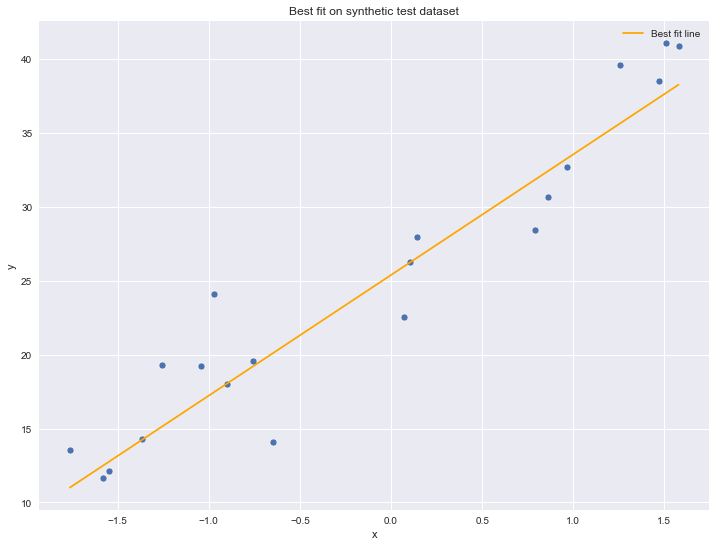

In [188]:
plt.figure(figsize=(12, 9))

sns.scatterplot(x=X_test[:, 1], y=y_test)
sns.lineplot(x=X_test[:, 1], y=vanilla_test_pred, label='Best fit line', color='orange')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Best fit on synthetic test dataset');

**Train a linear regression model ($\alpha = 0$) on the auto MPG training data. Make predictions and report the mean-squared error (MSE) on the training, validation, and test sets. Report the first 5 predictions on the test set, along with the actual labels.**

In [189]:
from sklearn.metrics import mean_squared_error


# no regularization 
alpha = 0


# train
linear_reg = LinearRegression(alpha)
linear_reg.train(auto_mpg_X_train, auto_mpg_y_train)

# predict on train set
train_pred = linear_reg.predict(auto_mpg_X_train)

# predict on validation set
val_pred = linear_reg.predict(auto_mpg_X_val)

# predict on test set
test_pred = linear_reg.predict(auto_mpg_X_test)


# MSE on train set
train_mse = mean_squared_error(auto_mpg_y_train, train_pred)

# MSE on validation set
val_mse = mean_squared_error(auto_mpg_y_val, val_pred)

# MSE on test set
test_mse = mean_squared_error(auto_mpg_y_test, test_pred)


print('MSE on train set: {}\nMSE on validation set: {}\nMSE on test set: {}'.format(train_mse, val_mse, test_mse))


MSE on train set: 0.11295739597002309
MSE on validation set: 0.1558403501927734
MSE on test set: 0.11584702643637534


In [190]:
print('First 5 (prediction, label) tuples on test set\n')

for i in range(5):
  print((test_pred[i], auto_mpg_y_test[i]))

First 5 (prediction, label) tuples on test set

(0.389372593168969, 0.6426722441293357)
(0.2816071936681116, -0.03846425198133965)
(-1.8020149242460706, -1.8928298799912)
(1.2226103560724646, 1.5565135947384496)
(1.1766090387345705, 1.206021039584204)


**As a baseline model, use the mean of the training labels (auto_mpg_y_train) as the prediction for all instances. Report the mean-squared error (MSE) on the training, validation, and test sets using this baseline.** This is a common baseline used in regression problems and tells you if your model is any good. Your linear regression MSEs should be much lower than these baseline MSEs.

In [191]:
# mean of training labels
mean_pred = np.mean(auto_mpg_y_train)

# Baseline MSE on train set
train_mse_base = mean_squared_error(auto_mpg_y_train, mean_pred*np.ones(auto_mpg_y_train.shape))

# Baseline MSE on validation set
val_mse_base = mean_squared_error(auto_mpg_y_val, mean_pred*np.ones(auto_mpg_y_val.shape))

# Baseline MSE on validation set
test_mse_base = mean_squared_error(auto_mpg_y_test, mean_pred*np.ones(auto_mpg_y_test.shape))

print('Baseline MSE on train set: {}\nBaseline MSE on validation set: {}\nBaseline MSE on test set: {}'.format(train_mse_base, val_mse_base, test_mse_base))



Baseline MSE on train set: 1.0000000000000002
Baseline MSE on validation set: 1.1155834283230353
Baseline MSE on test set: 1.0632809676711108


**Interpret your model trained on the auto MPG dataset using a bar chart of the model weights.** Make sure to label the bars (x-axis) and don't forget the bias term!

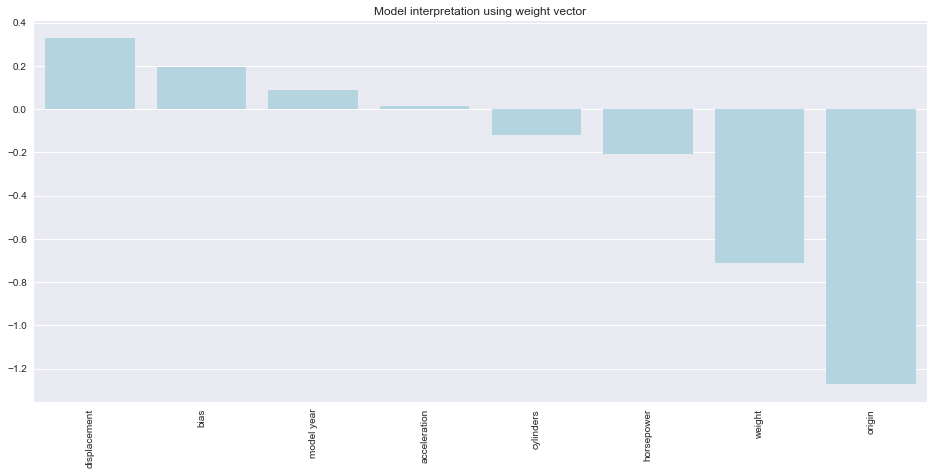

In [192]:
w = list(linear_reg.w[0:5])
w.append(sum(list(linear_reg.w)[5:8]))
w.append(linear_reg.w[8])
w.append(linear_reg.w[9])

features = ['bias']
features = features + numeric_features + nominal_features + ordinal_features

plt.figure(figsize=(16,7))

features, w = list(zip(*sorted(list(zip(features, w)), key=lambda x: x[1], reverse=True)))

ax = sns.barplot(x=list(features), y=list(w), color='lightblue')

ax.tick_params(axis='x', rotation=90)
ax.set_title('Model interpretation using weight vector');

**According to your model, which features are the greatest contributors to the MPG?**

From the graph above, displacement, weight, and origin are the greatest contributors.

### 1.5 Tune Regularization Parameter $\alpha$

Now, let's do ridge regression and tune the $\alpha$ regularization parameter on the auto MPG dataset.

**Sweep out values for $\alpha$ using `alphas = np.logspace(-2, 1, 10)`. Perform a grid search over these $\alpha$ values, recording the training and validation MSEs for each $\alpha$. A simple grid search is fine, no need for k-fold cross validation. Plot the training and validation MSEs as a function of $\alpha$ on a single figure. Make sure to label the axes and the training and validation MSE curves. Use a log scale for the x-axis.**

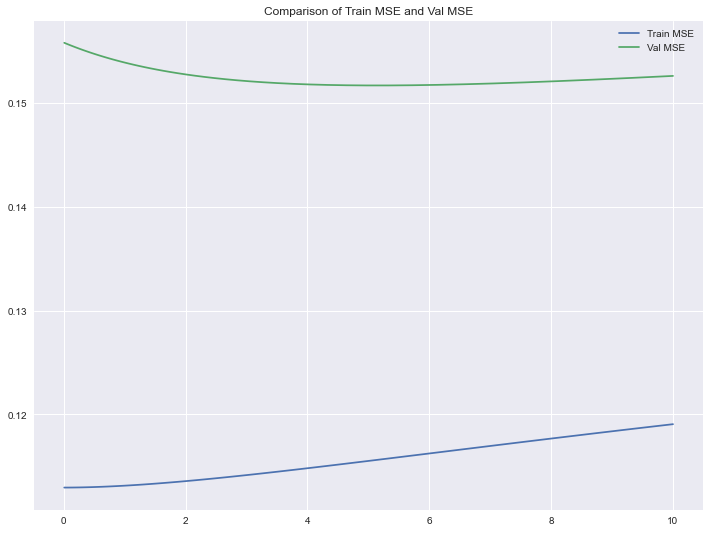

In [193]:
alphas = np.logspace(-2, 1, 100)
train_mse_ = []
val_mse_ = []

for alpha in alphas:
    # train
    linear_reg = LinearRegression(alpha)
    linear_reg.train(auto_mpg_X_train, auto_mpg_y_train)
    
    # predict on train set
    train_pred = linear_reg.predict(auto_mpg_X_train)
  
    # predict on validation set
    val_pred = linear_reg.predict(auto_mpg_X_val)
    
    # prediction on test set
    test_pred = linear_reg.predict(auto_mpg_X_test)

    # MSE on train set
    train_mse = mean_squared_error(auto_mpg_y_train, train_pred)

    # MSE on validation set
    val_mse = mean_squared_error(auto_mpg_y_val, val_pred)

    train_mse_.append(train_mse)
    val_mse_.append(val_mse)



plt.figure(figsize=(12,9))

sns.lineplot(x=alphas, y=train_mse_, label='Train MSE')
sns.lineplot(x=alphas, y=val_mse_, label='Val MSE')

plt.title('Comparison of Train MSE and Val MSE');

**Explain your plot above. How do training and validation MSE behave with decreasing model complexity (increasing $\alpha$)?**

We can see that when alpha is low, model overfits: train MSE is low but Val MSE is high, as alpha increases, we find a sweet spot where both the MSEs are close as well as low, after that both  Train and Val MSE increase significantly, indicating underfit.

**Using the $\alpha$ which gave the best validation MSE above, train a model on the training set. Report the value of $\alpha$ and its training, validation, and test MSE.** This is the final tuned model which you would deploy in production.

In [194]:
alphas = np.logspace(-2, 1, 100)
idx = [i for i in range(len(alphas))]
sorted(list(zip(val_mse_,idx)), key=lambda x: x[0])[0]


(0.1517070638203137, 89)

In [195]:
from sklearn.metrics import mean_squared_error


# set alpha for regularization 
alpha = alphas[89]

# train
linear_reg = LinearRegression(alpha)
linear_reg.train(auto_mpg_X_train, auto_mpg_y_train)

# predict on train set
train_pred = linear_reg.predict(auto_mpg_X_train)

# predict on validation set
val_pred = linear_reg.predict(auto_mpg_X_val)

# predict on test set
test_pred = linear_reg.predict(auto_mpg_X_test)


# MSE on train set
train_mse = mean_squared_error(auto_mpg_y_train, train_pred)

# MSE on validation set
val_mse = mean_squared_error(auto_mpg_y_val, val_pred)

# MSE on test set
test_mse = mean_squared_error(auto_mpg_y_test, test_pred)

print('MSE on train set: {}\nMSE on validation set: {}\nMSE on test set: {}'.format(train_mse, val_mse, test_mse))


MSE on train set: 0.11550573335806197
MSE on validation set: 0.1517070638203137
MSE on test set: 0.11740559270150337


## Part 2: Logistic Regression

### 2.1 Data Exploration

<img src="https://pathology.jhu.edu/build/assets/breast/_image1200/368/ILC.jpg" alt="cells" width="400"/>

In parts 2 and 3, we will be using a [breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) for classification. Given 30 continuous features describing the nuclei of cells in a digitized image of a [fine needle aspirate (FNA)](https://www.cancer.org/cancer/breast-cancer/screening-tests-and-early-detection/breast-biopsy/fine-needle-aspiration-biopsy-of-the-breast.html) of a breast mass, we will train logistic regression and SVM models to classify each sample as benign (B) or malignant (M).

In [196]:
ccr_df = pd.read_csv('breast-cancer.csv')
ccr_df = ccr_df.drop(columns=['id', 'Unnamed: 32'])
ccr_df


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [197]:
f'No. of examples: {ccr_df.shape[0]}'

'No. of examples: 569'

In [198]:
ccr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

We can see that apart from diagnosis, which is the target variable, all the remaining columns are continuous. I also inspected each column to see if categorical values were present as float, but this wasn't the case. It is confirmed that all these features are indeed continuous.

We also see that there are no missing values.

In [199]:
print('Features:',', '.join(ccr_df.columns.values[1:]))
print('\nLabel: {}'.format(ccr_df.columns.values[0]))
print('\nNo. of features: {}'.format(len(ccr_df.columns)-1))

Features: radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst

Label: diagnosis

No. of features: 30


In [200]:
ccr_df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

Hence, this is a binary classification problem and the classes are fairly well balanced.

In [201]:
# Split data into features and labels
ccr_X = ccr_df.drop(columns=['diagnosis'])
ccr_y = ccr_df['diagnosis']

**Compute the distribution of the labels. What is the probability of observing the majority class?** This is a common baseline for accuracy in classification problems.

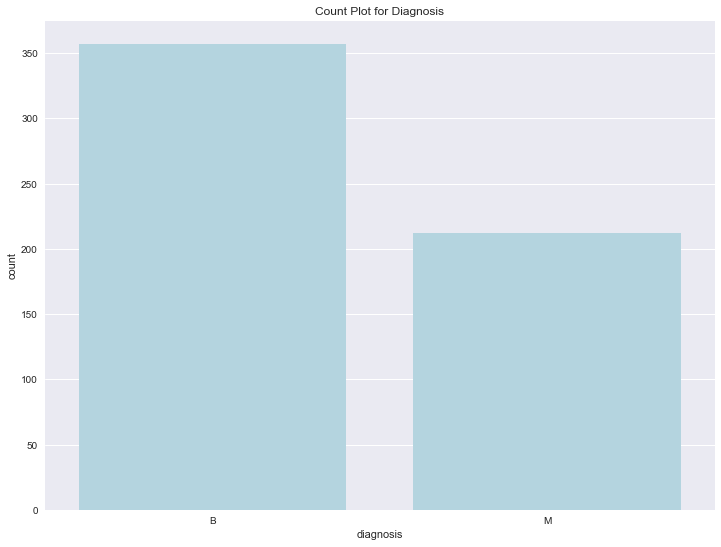

In [202]:
### Your code here
plt.figure(figsize=(12,9))

sns.countplot(x=ccr_y, order=['B', 'M'], color='lightblue')

plt.xlabel('diagnosis')
plt.ylabel('count')
plt.title('Count Plot for Diagnosis');

We see that 'B' is the majority class here. Also, the classes are not heavily imbalanced, so we can focus on improving accuracy.

In [203]:
print('Probability of observing the majority class B = {}'.format(ccr_df['diagnosis'].value_counts()['B']/len(ccr_df)))


Probability of observing the majority class B = 0.6274165202108963


**Plot the relationships between the label (diagnosis) and the 30 features using a small multiple of box plots. Make sure to label the axes.**

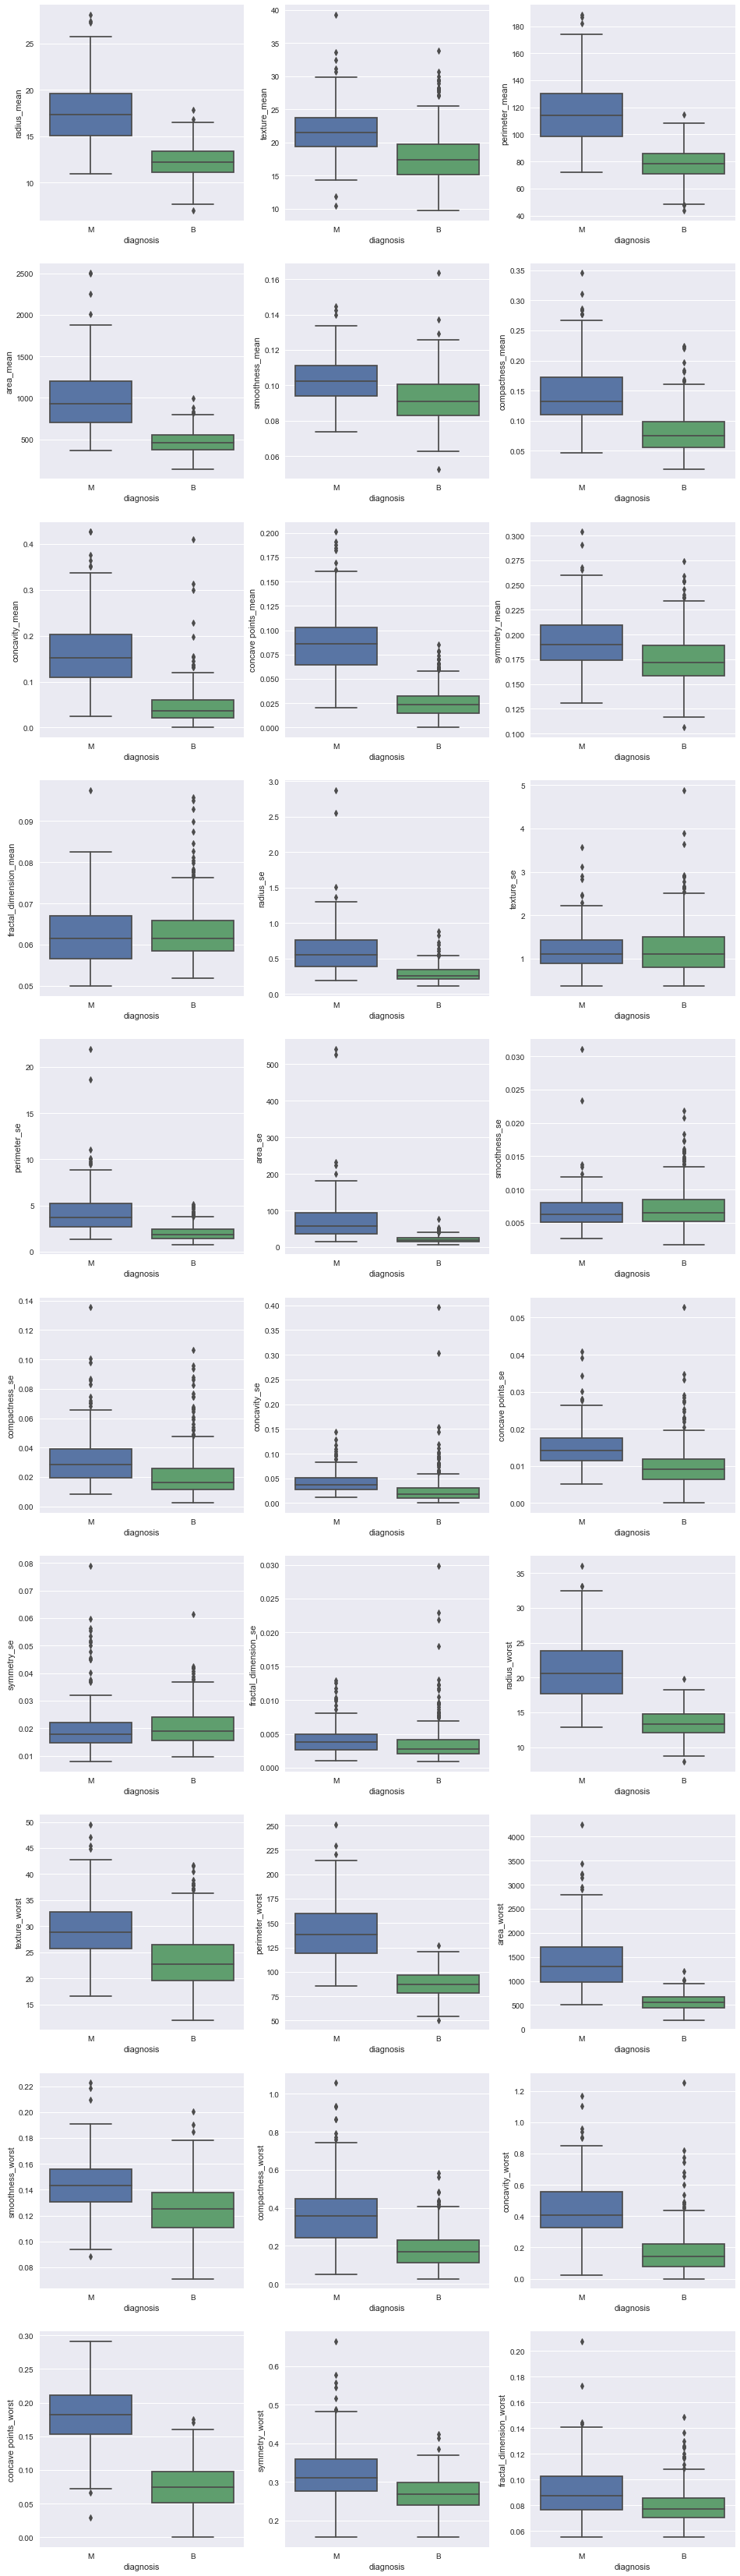

In [204]:
fig, axes = plt.subplots(10, 3, figsize=(16,60))

k = 0
for i in range(10):
    for j in range(3):
        sns.boxplot(x=ccr_y, y=ccr_X[ccr_X.columns.values[k]], ax=axes[i][j])
        axes[i][j].set(xlabel='diagnosis', ylabel=ccr_X.columns.values[k]);
        k += 1


### 2.2 Data Pre-processing

**Apply the following pre-processing steps to the breast cancer dataset:**

1. Encode the categorical label as 0 (B) or 1 (M).
2. Convert the label from a Pandas series to a Numpy (m x 1) vector. If you don't do this, it may cause problems when implementing the logistic regression model (certain broadcasting operations may fail unexpectedly).
2. Split the dataset into training (60%), validation (20%), and test (20%) sets.
3. Standardize the columns in the feature matrices cancer_X_train, cancer_X_val, and cancer_X_test to have zero mean and unit variance. To avoid information leakage, learn the standardization parameters (mean, variance) from cancer_X_train, and apply it to cancer_X_train, cancer_X_val, and cancer_X_test.
4. Add a column of ones to the feature matrices cancer_X_train, cancer_X_val, and cancer_X_test. This is a common trick so that we can learn a coefficient for the bias term of a linear model.


In [205]:
# label encoding 
codes = {'B': 0, 'M': 1}
ccr_y.replace(codes, inplace=True)

ccr_y = ccr_y.to_numpy().reshape(-1, 1)
ccr_y[0:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

In [206]:
#1. No categorical features present


#2. Split the dataset into training (60%), validation (20%), and test (20%) sets
ccr_X_dev, ccr_X_test, ccr_y_dev, ccr_y_test = train_test_split(ccr_X, ccr_y, test_size=.2, random_state=0)
ccr_X_train, ccr_X_val, ccr_y_train, ccr_y_val = train_test_split(ccr_X_dev, ccr_y_dev, test_size=.25, random_state=0)


#3. Standardize continuous features
sc = StandardScaler()
ccr_X_train = sc.fit_transform(ccr_X_train)           # Fit and transform scalar on train dataset
ccr_X_val = sc.transform(ccr_X_val)                   # transform validation dataset
ccr_X_test = sc.transform(ccr_X_test)                 # transform test dataset


#4. Add a column of ones to the feature matrices
ccr_X_train = np.hstack([np.ones((ccr_X_train.shape[0], 1)), ccr_X_train])
ccr_X_val = np.hstack([np.ones((ccr_X_val.shape[0], 1)), ccr_X_val])
ccr_X_test = np.hstack([np.ones((ccr_X_test.shape[0], 1)), ccr_X_test])


At the end of this pre-processing, you should have the following vectors and matrices: ccr_X_train, ccr_X_val, ccr_X_test, ccr_y_train, ccr_y_val, ccr_y_test.

### 2.3 Implement Logistic Regression

We will now implement logistic regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for logistic regression is:

$$
y = \sigma(X w)
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$, i.e. the sigmoid function. This function scales the prediction to be a probability between 0 and 1, and can then be thresholded to get a discrete class prediction.

Just as with linear regression, our objective in logistic regression is to learn the weights $𝑤$ which best fit the data. For L2-regularized logistic regression, we find an optimal $w$ to minimize the following loss function:

$$
\min_{w} \ -y^T \ \text{log}(\sigma(Xw)) \ - \  (\mathbf{1} - y)^T \ \text{log}(\mathbf{1} - \sigma(Xw)) \ + \ \alpha \| w \|^2_2 \\
$$

Unlike linear regression, however, logistic regression has no closed-form solution for the optimal $w$. So, we will use gradient descent to find the optimal $w$. The (n x 1) gradient vector $g$ for the loss function above is:

$$
g = X^T \Big(\sigma(Xw) - y\Big) + 2 \alpha w
$$

Below is pseudocode for gradient descent to find the optimal $w$. You should first initialize $w$ (e.g. to a (n x 1) zero vector). Then, for some number of epochs $t$, you should update $w$ with $w - \eta g $, where $\eta$ is the learning rate and $g$ is the gradient. You can learn more about gradient descent [here](https://www.coursera.org/lecture/machine-learning/gradient-descent-8SpIM).

> $w = \mathbf{0}$
> 
> $\text{for } i = 1, 2, ..., t$
>
> $\quad \quad w = w - \eta g $


**Implement a `LogisticRegression` class with five methods: `train`, `predict`, `calculate_loss`, `calculate_gradient`, and `calculate_sigmoid`.** You may NOT use sklearn for this implementation. It is highly recommended that you vectorize your code.

In [207]:
class LogisticRegression():
    '''
    Logistic regression model with L2 regularization.

    Attributes
    ----------
    alpha: regularization parameter
    t: number of epochs to run gradient descent
    eta: learning rate for gradient descent
    w: (n x 1) weight vector
    '''

    def __init__(self, alpha=0, t=100, eta=1e-3):
        self.alpha = alpha
        self.t = t
        self.eta = eta
        self.w = None


    def train(self, X, y):
        '''Trains logistic regression model using gradient descent 
        (sets w to its optimal value).

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        losses: (t x 1) vector of losses at each epoch of gradient descent
        '''
        
        m = X.shape[0]
        n = X.shape[1]

        # store losses
        losses = np.zeros((self.t, 1))     

        # initialize w to zero vector
        self.w = np.zeros((n, 1))

        for i in range(self.t):
            # calculate gradient
            grad = self.calculate_gradient(X, y)

            # update parameter
            self.w = self.w - eta*grad

            # calculate loss with updated parameter
            losses[i, 0] = self.calculate_loss(X, y)

        return losses


    def predict(self, X):
        '''Predicts on X using trained model. Make sure to threshold 
        the predicted probability to return a 0 or 1 prediction.

        Parameters
        ----------
        X : (m x n) feature matrix

        Returns
        -------
        y_pred: (m x 1) 0/1 prediction vector
        '''
 
        return list(map(int, self.calculate_sigmoid(np.matmul(X, self.w)) > 0.5))


    def calculate_loss(self, X, y):
        '''Calculates the logistic regression loss using X, y, w, 
        and alpha. Useful as a helper function for train().

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        loss: (scalar) logistic regression loss
        '''
    
        loss = np.matmul(np.transpose(y), np.log(self.calculate_sigmoid(np.matmul(X, self.w))))
        loss += np.matmul(np.transpose(1-y), np.log(1-self.calculate_sigmoid(np.matmul(X, self.w))))
        loss *= (-1)
        loss += self.alpha*np.matmul(np.transpose(self.w), self.w)

        return loss
        
    
    def calculate_gradient(self, X, y):
        '''Calculates the gradient of the logistic regression loss 
        using X, y, w, and alpha. Useful as a helper function 
        for train().
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        gradient: (n x 1) gradient vector for logistic regression loss
        '''
       
        
        return np.matmul(np.transpose(X), (self.calculate_sigmoid(np.matmul(X, self.w)) - y) ) + 2*self.alpha*self.w
    
    
    def calculate_sigmoid(self, x):
        '''Calculates the sigmoid function on each element in vector x. 
        Useful as a helper function for predict(), calculate_loss(), 
        and calculate_gradient().
        
        Parameters
        ----------
        x: (m x 1) vector
        
        Returns
        -------
        sigmoid_x: (m x 1) vector of sigmoid on each element in x
        '''
  
        return 1/(1 + np.exp(-x))
    

### 2.4 Train, Evaluate, and Interpret Logistic Regression Model

**Using your implementation above, train a logistic regression model (alpha=0, t=100, eta=1e-3) on the breast cancer training data. Plot the training loss over epochs. Make sure to label your axes.** You should see the loss decreasing and start to converge.

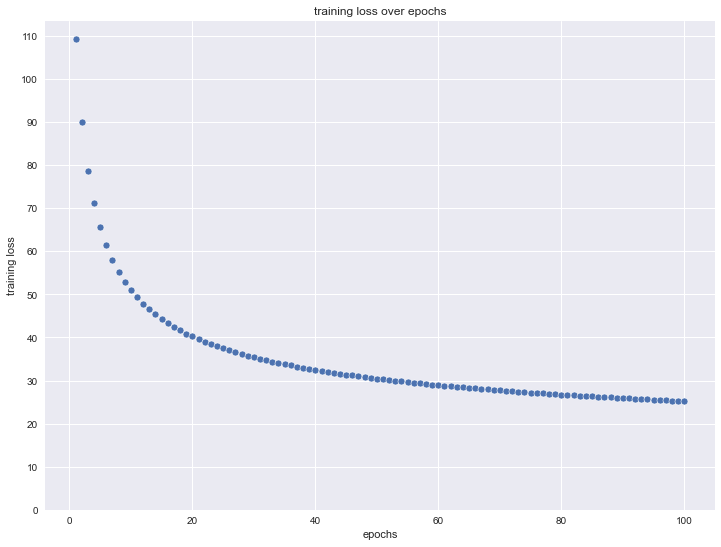

In [208]:
# set options
alpha = 0
t = 100
eta = 1e-3

# build model
lr = LogisticRegression(alpha, t, eta)

# train
losses = lr.train(ccr_X_train, ccr_y_train)

# plot training loss vs epoch
plt.figure(figsize=(12,9))
sns.scatterplot(x=np.arange(1, 101, 1), y=losses.reshape(-1))

plt.yticks(np.arange(0, losses.reshape(-1).max()+1, 10))
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('training loss over epochs');


**Use your trained model to make predictions and report the accuracy on the training, validation, and test sets. Report the first 5 predictions on the test set, along with the actual labels.** Your accuracies should be much higher than the baseline accuracy we found in Section 2.1.

In [209]:
from sklearn.metrics import accuracy_score

# on training dataset
ccr_y_pred_train = lr.predict(ccr_X_train)
accuracy_train = accuracy_score(ccr_y_train.reshape(-1), ccr_y_pred_train)


# on validation dataset
ccr_y_pred_val = lr.predict(ccr_X_val)
accuracy_val = accuracy_score(ccr_y_val.reshape(-1), ccr_y_pred_val)


# on test dataset
ccr_y_pred_test = lr.predict(ccr_X_test)
accuracy_test = accuracy_score(ccr_y_test.reshape(-1), ccr_y_pred_test)



print('Accuracy score on train dataset: {}\nAccuracy score on validation dataset {}\nAccuracy score on test dataset: {}'.format(accuracy_train, accuracy_val, accuracy_test))
print('First 5 (prediction, actual label) on test set: {}'.format(list(zip(ccr_y_pred_test[0:5], ccr_y_test.reshape(1, -1)[0].tolist()))))



Accuracy score on train dataset: 0.9882697947214076
Accuracy score on validation dataset 0.9649122807017544
Accuracy score on test dataset: 0.956140350877193
First 5 (prediction, actual label) on test set: [(1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


**Interpret your trained model using a bar chart of the model weights.** Make sure to label the bars (x-axis) and don't forget the bias term! Use lecture 3, slide 15 as a reference.

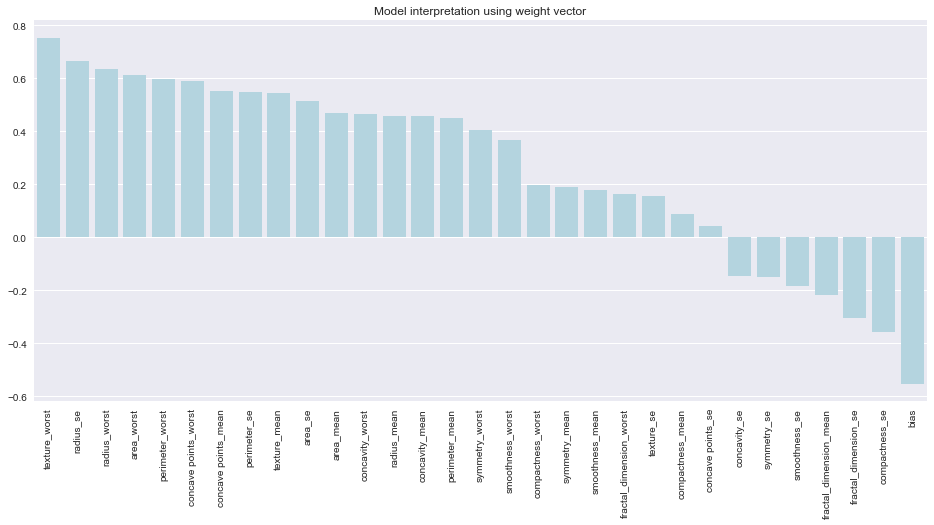

In [210]:
plt.figure(figsize=(16,7))

feature_names = ['bias']
feature_names += ccr_X.columns.tolist()
feature_names_, weights_ = list(zip(*sorted(list(zip(feature_names, lr.w.reshape(1,-1)[0].tolist())), key=lambda x: x[1], reverse=True)))

ax = sns.barplot(x=list(feature_names_), y=list(weights_), color='lightblue')

ax.tick_params(axis='x', rotation=90)
ax.set_title('Model interpretation using weight vector');


We can see that for most features (except the last 7 in above graph and excluding bias), increase in their values would indicate greater probability of being classified as 'M' by our model.

**According to your model, which features are the greatest contributors to the diagnosis?**

In [211]:
print('texture_worst, radius_se, radius_worst, compactness_se are some of the greatest contributors to the diagnosis')


texture_worst, radius_se, radius_worst, compactness_se are some of the greatest contributors to the diagnosis


### 2.5 Tune Regularization Parameter  𝛼

Now, we will observe the effect of tuning the regularization parameter $\alpha$ on the learned weights of the model.

**Sweep out values for $\alpha$ using `alphas = np.logspace(-2, 2, 100)`. For each $\alpha$ value, train a logistic regression model and record its weights. Plot the weights for each feature as a function of $\alpha$ on a single figure. Make sure to label the axes.** You should have 31 curves (one for each feature) in the plot.

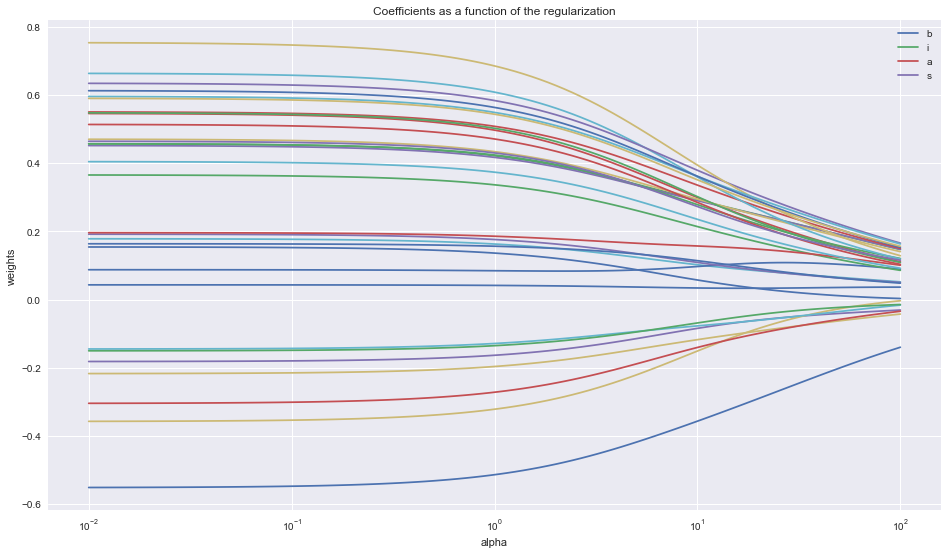

In [212]:
alphas = np.logspace(-2, 2, 100)
weights = []
ccr_y_pred_val = lr.predict(ccr_X_val)
accuracy_val = accuracy_score(ccr_y_val.reshape(-1), ccr_y_pred_val)
train_score = []
test_score = []

for alpha in alphas:
    lr = LogisticRegression(alpha=alpha)
    lr.train(ccr_X_train, ccr_y_train)
    weights.append(lr.w.flatten())
    ccr_y_pred_train = lr.predict(ccr_X_train)
    train_score.append(accuracy_score(ccr_y_train.reshape(-1), ccr_y_pred_train))
    ccr_y_pred_test = lr.predict(ccr_X_test)
    test_score.append(accuracy_score(ccr_y_test.reshape(-1), ccr_y_pred_test))
    

    
plt.figure(figsize=(16,9))

plt.plot(alphas, weights);

plt.legend('bias')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Coefficients as a function of the regularization');

**Describe the effect of the regularization parameter $\alpha$ on the weights of your model. Please explain in terms of model complexity.**

Except for the bias term, coefficients for all features tend towards $0$ as $\alpha$ is increased.

This is in consistent with our knowledge of how regularization works.

As $\alpha$ increases, it penalizes coefficients having higher magnitude and sends them towards $0$.

In terms of model complexity, our model becomes simpler as $\alpha$ is increased and for large values of $\alpha$, it starts to underfit because of weights being neglibile in terms of their magnitude.

For small values of $\alpha$, weights can vary in terms of magnitude because of which our model has higher variance and performs poorly on unseen data (overfits the training data).

## Part 3: SVM

You are allowed to use sklearn or any ML library in this part.

### 3.1 Train Primal SVM

**Train a primal SVM (with default parameters) on the breast cancer training data. Make predictions and report the accuracy on the training, validation, and test sets.**

In [213]:
# load the dataset
ccr_df = pd.read_csv('breast-cancer.csv')
ccr_df = ccr_df.drop(columns=['id', 'Unnamed: 32'])
ccr_df

# Split data into features and labels
ccr_X = ccr_df.drop(columns=['diagnosis'])
ccr_y = ccr_df['diagnosis']

# train test split
ccr_X_dev, ccr_X_test, ccr_y_dev, ccr_y_test = train_test_split(ccr_X, ccr_y, test_size=.2, random_state=0)
ccr_X_train, ccr_X_val, ccr_y_train, ccr_y_val = train_test_split(ccr_X_dev, ccr_y_dev, test_size=.25, random_state=0)


In [214]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC, SVC



num_features = [
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean',
    'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
    'fractal_dimension_se', 'radius_worst', 'texture_worst',
    'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave points_worst',
    'symmetry_worst', 'fractal_dimension_worst'
]

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, num_features)]
) # remaining columns will be dropped by default

In [215]:
# Primal SVM
primal = Pipeline(steps=[('preprocessor', preprocessor),
                      ('primalSVM', LinearSVC(dual=False))])

primal.fit(ccr_X_train, ccr_y_train)


print('Primal SVM with default parameters...')
print('Training accuracy: {}'.format(primal.score(ccr_X_train, ccr_y_train)))
print('Validation accuracy: {}'.format(primal.score(ccr_X_val, ccr_y_val)))
print('Test accuracy: {}'.format(primal.score(ccr_X_test, ccr_y_test)))

Primal SVM with default parameters...
Training accuracy: 0.9912023460410557
Validation accuracy: 0.9298245614035088
Test accuracy: 0.9473684210526315


In [216]:
print('(Actual, Prediction) on train dataset:')
print(list(zip(ccr_y_train, primal.predict(ccr_X_train)))[0:5])

(Actual, Prediction) on train dataset:
[('M', 'M'), ('B', 'B'), ('B', 'B'), ('M', 'M'), ('B', 'B')]


In [217]:
print('(Actual, Prediction) on val dataset:')
print(list(zip(ccr_y_val, primal.predict(ccr_X_val)))[0:5])

(Actual, Prediction) on val dataset:
[('M', 'M'), ('M', 'M'), ('B', 'B'), ('B', 'B'), ('M', 'M')]


In [218]:
print('(Actual, Prediction) on test dataset:')
print(list(zip(ccr_y_val, primal.predict(ccr_X_test)))[0:5])

(Actual, Prediction) on test dataset:
[('M', 'M'), ('M', 'B'), ('B', 'B'), ('B', 'B'), ('M', 'B')]


### 3.2 Train Dual SVM

**Train a dual SVM (with default parameters) on the breast cancer training data. Make predictions and report the accuracy on the training, validation, and test sets.**

In [219]:
# Dual SVM
dual = Pipeline(steps=[('preprocessor', preprocessor),
                      ('dualSVM', SVC(kernel='linear'))])

dual.fit(ccr_X_train, ccr_y_train)


print('Dual SVM with default parameters...')
print('Training accuracy: {}'.format(dual.score(ccr_X_train, ccr_y_train)))
print('Validation accuracy: {}'.format(dual.score(ccr_X_val, ccr_y_val)))
print('Test accuracy: {}'.format(dual.score(ccr_X_test, ccr_y_test)))

Dual SVM with default parameters...
Training accuracy: 0.9912023460410557
Validation accuracy: 0.9473684210526315
Test accuracy: 0.9649122807017544


In [220]:
print('(Actual, Prediction) on train dataset:')
print(list(zip(ccr_y_train, dual.predict(ccr_X_train)))[0:5])

(Actual, Prediction) on train dataset:
[('M', 'M'), ('B', 'B'), ('B', 'B'), ('M', 'M'), ('B', 'B')]


In [221]:
print('(Actual, Prediction) on val dataset:')
print(list(zip(ccr_y_val, dual.predict(ccr_X_val)))[0:5])

(Actual, Prediction) on val dataset:
[('M', 'M'), ('M', 'M'), ('B', 'B'), ('B', 'B'), ('M', 'M')]


In [222]:
print('(Actual, Prediction) on test dataset:')
print(list(zip(ccr_y_val, dual.predict(ccr_X_test)))[0:5])

(Actual, Prediction) on test dataset:
[('M', 'M'), ('M', 'B'), ('B', 'B'), ('B', 'B'), ('M', 'B')]


### 3.3 Number of Support Vectors

**Find the number of support vectors in your SVM model.**

In [223]:
print('Number of support vectors: {}'.format(dual[-1].support_vectors_.shape[0]))

Number of support vectors: 29


### 3.4 Hyperparameter Tuning

**Improve the SVM model (by hyperparameter tuning, feature selection, or using a non-linear SVM) to get better test performance than the dual SVM.**

In [224]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'primalSVM__C': np.linspace(0, 1, 10),
    'primalSVM__loss': ['squared_hinge', 'hinge'],
    'primalSVM__max_iter': [1000, 2000, 3000],
}

primal_grid = GridSearchCV(
    primal, 
    param_grid=param_grid,
    n_jobs=-1, 
    return_train_score=True,
    cv=10)

primal_grid.fit(ccr_X_dev, ccr_y_dev);


print('Tuned SVM...')
print('Best Parameters: {}'.format(primal_grid.best_params_))
print('Best Score: {}'.format(primal_grid.best_score_))
print('Train Accuracy: {}'.format(primal_grid.score(ccr_X_train, ccr_y_train)))
print('Validation Accuracy: {}'.format(primal_grid.score(ccr_X_val, ccr_y_val)))
print('Test Accuracy: {}\n\n\n\n'.format(primal_grid.score(ccr_X_test, ccr_y_test)))


Tuned SVM...
Best Parameters: {'primalSVM__C': 0.1111111111111111, 'primalSVM__loss': 'squared_hinge', 'primalSVM__max_iter': 1000}
Best Score: 0.973719806763285
Train Accuracy: 0.9882697947214076
Validation Accuracy: 0.9912280701754386
Test Accuracy: 0.9649122807017544






/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
330 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_c

which compares well to the dual svm performance


In order to use kernel other than linear, we need to use sklearn.svm.SVC

In [225]:
# rbf kernel svm
kernel_svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('kernelSVM', SVC(kernel='rbf'))])

kernel_svm.fit(ccr_X_train, ccr_y_train)

print('RBF SVM...')
print('Training accuracy: {}'.format(kernel_svm.score(ccr_X_train, ccr_y_train)))
print('Validation accuracy: {}'.format(kernel_svm.score(ccr_X_val, ccr_y_val)))
print('Test accuracy: {}'.format(kernel_svm.score(ccr_X_test, ccr_y_test)))

RBF SVM...
Training accuracy: 0.9853372434017595
Validation accuracy: 0.9824561403508771
Test accuracy: 0.9736842105263158


In [226]:
# GridSearchCV on Kernelized SVM
param_grid = {
    'kernelSVM__C': np.linspace(0, 2, 50),
    'kernelSVM__kernel': ['poly', 'rbf'],
    'kernelSVM__gamma': ['scale', 'auto'],
}

kernel_grid = GridSearchCV(
    kernel_svm, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=10)

kernel_grid.fit(ccr_X_dev, ccr_y_dev);

print('Tuned Kernelized SVM...')
print('Best Parameters: {}'.format(kernel_grid.best_params_))
print('Best Score: {}'.format(kernel_grid.best_score_))
print('Train Accuracy: {}'.format(kernel_grid.score(ccr_X_train, ccr_y_train)))
print('Validation Accuracy: {}'.format(kernel_grid.score(ccr_X_val, ccr_y_val)))
print('Test Accuracy: {}\n\n\n\n'.format(kernel_grid.score(ccr_X_test, ccr_y_test)))

Tuned Kernelized SVM...
Best Parameters: {'kernelSVM__C': 1.0612244897959182, 'kernelSVM__gamma': 'scale', 'kernelSVM__kernel': 'rbf'}
Best Score: 0.9780676328502416
Train Accuracy: 0.9853372434017595
Validation Accuracy: 0.9824561403508771
Test Accuracy: 0.9736842105263158






/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_b